Enter Number of Images: 12
Enter Threshold % for Plate: 50
Enter Threshold % for Vehicle: 50
0.999101 ___ 0 ___ 0
0.9989772 ___ 0 ___ 0
0.7056337 ___ 0 ___ 0
0 ___ 0 ___ 0
0.9983155 ___ 0 ___ 0
0.50308776 ___ 0.76071554 ___ 0
0.99852306 ___ 0 ___ 0
0.9996354 ___ 0 ___ 0
0.9618284 ___ 0.71689487 ___ 0
0 ___ 0.90058243 ___ 0
0.9938303 ___ 0 ___ 0
0 ___ 0 ___ 0
Given Number of Test Images:  12
Detected Plates:  9
Detected Cars:  3
Detected Bikes:  0
Plate => [0.999101, 0.9989772, 0.7056337, 0.9983155, 0.50308776, 0.99852306, 0.9996354, 0.9618284, 0.9938303]
Mean Average Precision for License Plates is:  91.0 %
Car => [0.76071554, 0.71689487, 0.90058243]
Mean Average Precision for Car is:  79.27309473355612 %
Bike => []
Mean Average Precision for Bike is:  0 %


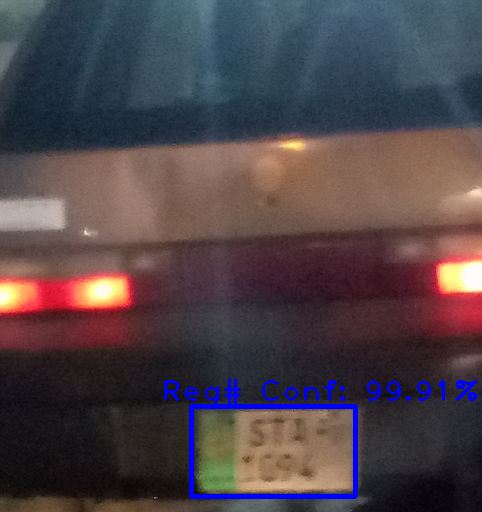

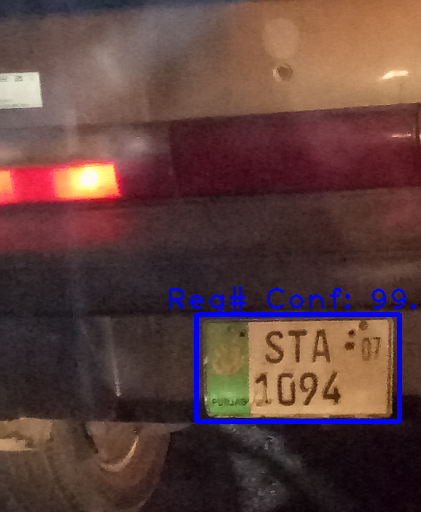

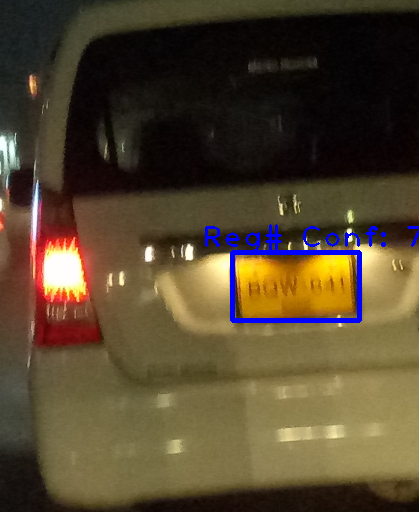

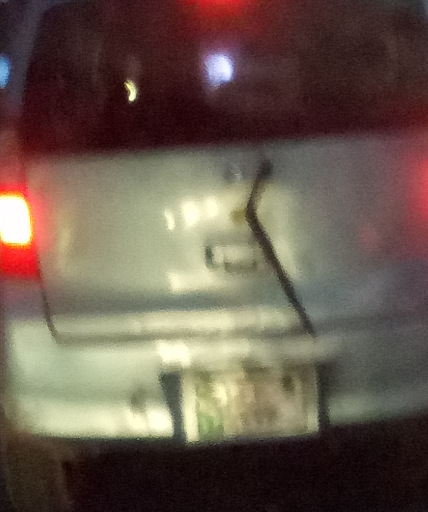

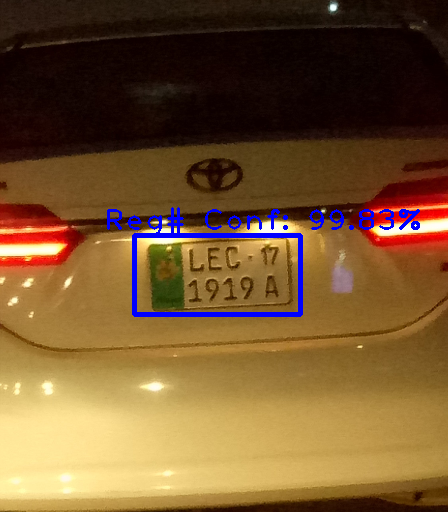

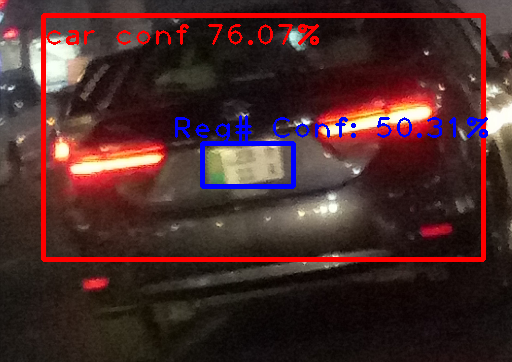

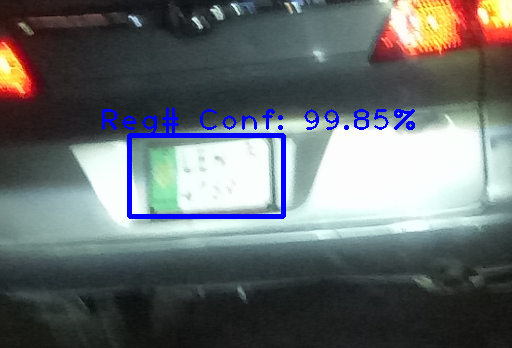

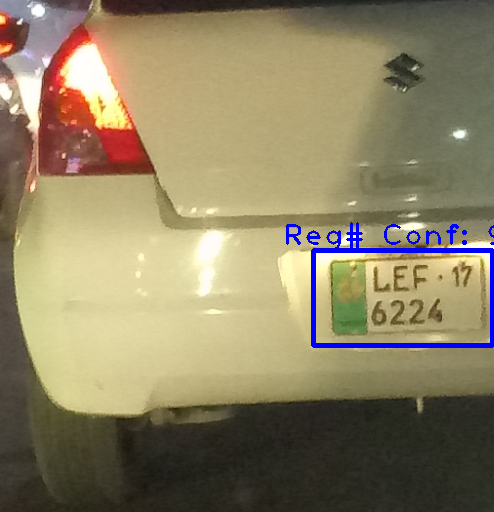

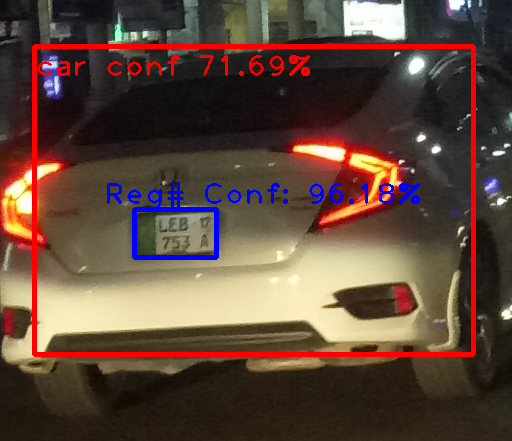

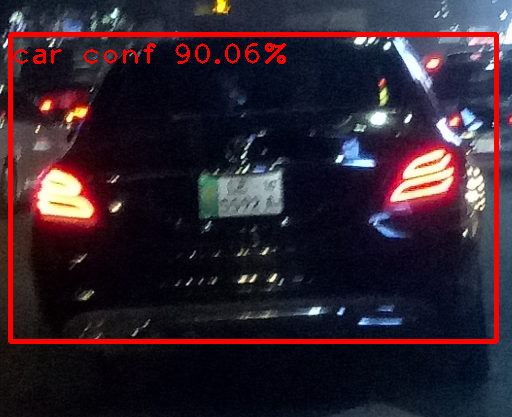

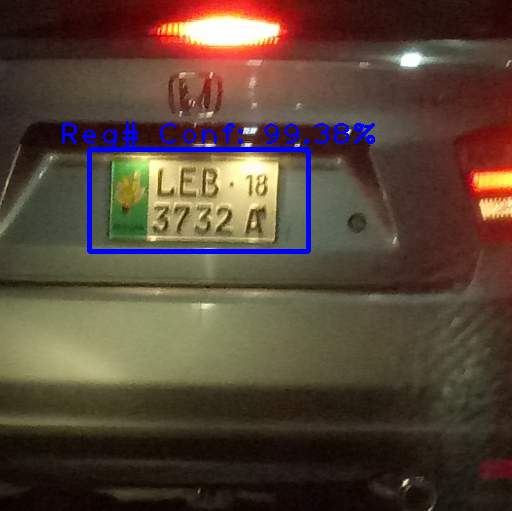

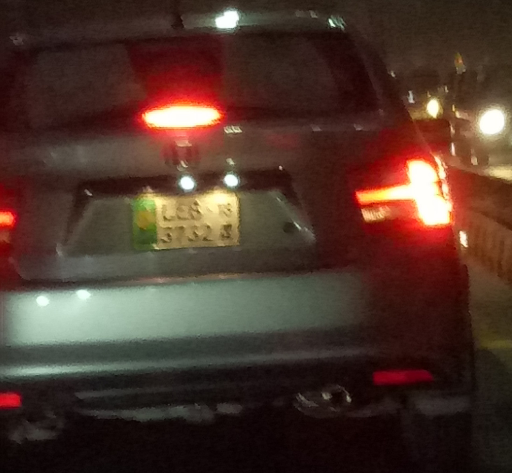

In [11]:
import cv2
import numpy as np
import pandas as pd
import glob
import random
from google.colab.patches import cv2_imshow

def objectDetector(img_path, plateTh, vehTh):
  # #### Load Yolo
  path = "/content/drive/MyDrive/ObjectDetection/"
  net = cv2.dnn.readNet(path+"yolov3.weights", path+"yolov3.cfg")
  filter_classes = ["motorbike","bus","truck","car"]
  classes = []
  with open(path+"coco.names", "r") as f:
      classes = [line.strip() for line in f.readlines()]

  # Load Yolo Custom
  net_custom = cv2.dnn.readNet("/content/drive/MyDrive/yolov3_training_final.weights", "/content/drive/MyDrive/yolov3_testing.cfg")

  # Name custom object
  classes_custom = ["Reg_Num_Plate"]

  # Images path
  images_path = glob.glob(img_path)





  layer_names = net.getLayerNames()
  output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
  colors = np.random.uniform(0, 255, size=(len(classes), 3))

  layer_names_custom = net_custom.getLayerNames()
  output_layers_custom = [layer_names_custom[i[0] - 1] for i in net_custom.getUnconnectedOutLayers()]
  colors_custom = np.random.uniform(0, 255, size=(len(classes_custom), 3))




  # Insert here the path of your images
  random.shuffle(images_path)




  # loop through all the images
  for img_path in images_path:
      # Loading image
      img = cv2.imread(img_path)
      img = cv2.resize(img, None, fx=0.4, fy=0.4)
      height, width, channels = img.shape

      # Detecting objects
      blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

      net.setInput(blob)
      outs = net.forward(output_layers)

      # Showing informations on the screen
      class_ids = []
      confidences = []
      boxes = []
      for out in outs:
          for detection in out:
              scores = detection[5:]
              class_id = np.argmax(scores)
              confidence = scores[class_id]
              if confidence > vehTh: # Car/Bike Threshold
                  Veh_Acc = confidence
                  # Object detected
                  center_x = int(detection[0] * width)
                  center_y = int(detection[1] * height)
                  w = int(detection[2] * width)
                  h = int(detection[3] * height)

                  # Rectangle coordinates
                  x = int(center_x - w / 2)
                  y = int(center_y - h / 2)

                  boxes.append([x, y, w, h])
                  confidences.append(float(confidence))
                  class_ids.append(class_id)

      indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
      bikeDet = False
      carDet = False
      #print(indexes)
      font = cv2.FONT_HERSHEY_PLAIN
      for i in range(len(boxes)):
          if i in indexes:
              x, y, w, h = boxes[i]
              label = str(classes[class_ids[i]])
              if label == "car" or label == "motorbike":
                color = colors[class_ids[i]]
                if label == filter_classes[0] or label == filter_classes[1] or label == filter_classes[2] or label == filter_classes[3]:
                  if label == filter_classes[0]:
                    bikeDet = True
                    accBike = Veh_Acc
                    color = (255,0,0)
                  elif label == filter_classes[3]:
                    carDet = True
                    color = (0,0,255)
                    accCar = Veh_Acc
                  cv2.rectangle(img, (x, y), (x + w, y + h+20), color, 3)
                  cv2.putText(img, label+" conf "+str(round(Veh_Acc*100,2))+"%", (x, y + 30), font, 2, color, 2)
          else:
              bikeDet, carDet = False, False
          
      #---------------------------------------------------------------------------
      
      net_custom.setInput(blob)
      outs = net_custom.forward(output_layers_custom)
      
      # Showing informations on the screen
      class_ids_custom = []
      confidences_custom = []
      boxes_custom = []
      plateDetect = False
      for out in outs:
          for detection in out:
              scores = detection[5:]
              class_id = np.argmax(scores)
              confidence = scores[class_id]
              if confidence > plateTh: #Plate Threshold
                  acc = confidence
                  plateDetect = True
                  # Object detected
                  center_x = int(detection[0] * width)
                  center_y = int(detection[1] * height)
                  w = int(detection[2] * width)
                  h = int(detection[3] * height)

                  # Rectangle coordinates
                  x = int(center_x - w / 2)
                  y = int(center_y - h / 2)

                  boxes_custom.append([x, y, w, h])
                  confidences_custom.append(float(confidence))
                  class_ids_custom.append(class_id)
                  plate = img[y:y+h+2, x:x+w-3]
             #elif confidence < 0.7:
              #    accPlate = 0
      colorBlue = (255,0,0)
      indexes_custom = cv2.dnn.NMSBoxes(boxes_custom, confidences_custom, 0.5, 0.4)
      #print(indexes_custom)
      accPlate = []
      font = cv2.FONT_HERSHEY_PLAIN
      for i in range(len(boxes_custom)):
          if i in indexes_custom:
              x, y, w, h = boxes_custom[i]
              
              label = str(classes_custom[class_ids_custom[i]])
              cv2.rectangle(img, (x, y), (x + w, y + h+2), colorBlue, 3)
              cv2.putText(img, "Reg# Conf: "+str(round(acc*100,2))+"%", (x-30, y - 5), font, 2, colorBlue, 2)            
  if carDet:
    if plateDetect:
      return acc, accCar, 0, img
    else:
      return 0, accCar, 0, img
  elif bikeDet:
    if plateDetect:
      return acc, 0, accBike, img
    else:
      return 0, 0, accBike, img
  else:
    if plateDetect:
      return acc, 0, 0, img
    else:
      return 0, 0, 0, img


plate = []
car = []
bike = []
n = int(input("Enter Number of Images: "))
plateTh = float(input("Enter Threshold % for Plate: "))
vehTh = float(input("Enter Threshold % for Vehicle: ")) 
plateTh, vehTh = plateTh/100, vehTh/100
images = []
for i in range(1,n+1):
  input_image_path = r"/content/drive/MyDrive/CarImages/car"+str(i)+".jpeg"
  plateAcc, carAcc, bikeAcc, imgs = objectDetector(input_image_path, plateTh, vehTh)
  print(plateAcc,"___", carAcc,"___", bikeAcc)
  if plateAcc != 0:
    plate.append(plateAcc)
  if carAcc != 0:
    car.append(carAcc)
  if bikeAcc != 0:
    bike.append(bikeAcc)
  images.append(imgs)


print("Given Number of Test Images: ", n)
print("Detected Plates: ", len(plate))
print("Detected Cars: ", len(car))
print("Detected Bikes: ", len(bike))


print("Plate =>",plate)

if len(plate) == 0:
  plateP = 0
else:
  plateP = round(sum(plate)/len(plate),2)*100
print("Mean Average Precision for License Plates is: ",plateP,"%")
print("Car =>",car)
if len(car) == 0:
  carP = 0
else:
  carP = (sum(car)/len(car))*100
print("Mean Average Precision for Car is: ",carP,"%")
print("Bike =>", bike)
if len(bike) == 0:
  bikeP = 0
else:
  bikeP = round(sum(bike)/len(bike),2)*100
print("Mean Average Precision for Bike is: ",bikeP,"%")

for i in range(len(images)):
  cv2_imshow(images[i])
